In [6]:
# import libraries
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset

In [8]:
# Checking if gpu is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
# Transforms
transformer = transforms.Compose([

    # To resize all the images into a certain size
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    # Converting into torch.tensor
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
])

In [11]:
# Defining the dataset class

class Data_train(Dataset):

  def __init__(self, transform):
    # Loading dataset with labels
    path = os.path.join('Dataset\images\train\seg_train')
    classes = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
    self.n_samples = 0
    
    import PIL.Image as Image
    import glob

    # To obtain path of all classes
    file_list = glob.glob(path + "*")
    train_data = []

    for class_path in file_list:
      # Obtaining the class names alone
      class_name = class_path.split('/')[-1]

      # Loading all the images as paths
      for img_path in glob.glob(class_path + '/*'):

        train_data.append((Image.open(img_path), classes[class_name]))
        self.n_samples+=1
        
    self.data = train_data
    self.transform = transform

  def __getitem__(self, index):

    return self.transform(self.data[index][0]), self.data[index][1]

  def __len__(self):
    return self.n_samples


    # Defining the dataset class

class Data_test(Dataset):

  def __init__(self, transform):
    # Loading dataset with labels
    path = os.path.join('F:\PythonLearning\ML\Pytorch projects\Projects\CNN proj 1\Intel image classification\Dataset\images\test\seg_test')
    classes = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
    self.n_samples = 0
    
    import PIL.Image as Image
    import glob

    # To obtain path of all classes
    file_list = glob.glob(path + "*")
    train_data = []

    for class_path in file_list:
      # Obtaining the class names alone
      class_name = class_path.split('/')[-1]

      # Loading all the images as paths
      for img_path in glob.glob(class_path + '/*'):
        train_data.append((Image.open(img_path), classes[class_name]))
        self.n_samples+=1
        
    self.data = train_data
    self.transform = transform

  def __getitem__(self, index):

    return self.transform(self.data[index][0]), self.data[index][1]

  def __len__(self):
    return self.n_samples

In [12]:
dataset_train = Data_train(transformer)
dataset_test = Data_test(transformer)

In [13]:
test_path = os.path.join('/content/drive/MyDrive/ML/CNN Proj 1/Dataset/images/test')

train_loader = DataLoader(dataset_train, batch_size=256, shuffle=True)

test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

ValueError: num_samples should be a positive integer value, but got num_samples=0

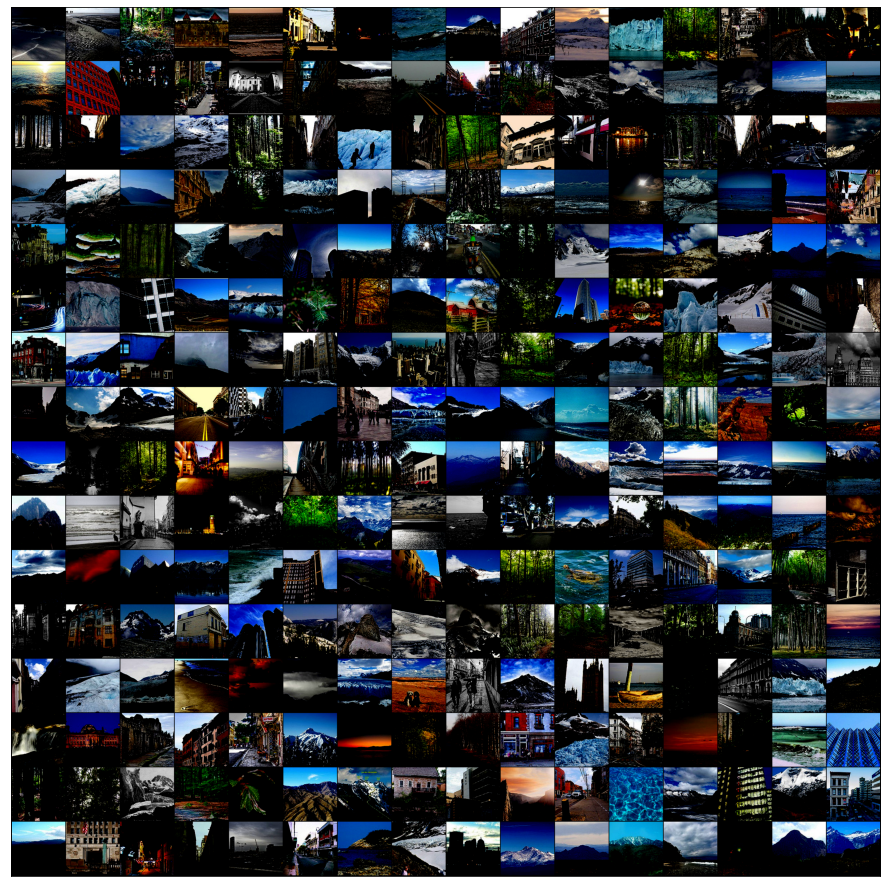

In [ ]:
"""
Data Visualizing Techniques (Note: as we break after a single iteration over a batch we're only printing the data in one batch (256 images))
"""

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for i, (image, label) in enumerate(train_loader):
    fig,ax = plt.subplots(figsize = (16,16))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(image,nrow=16).permute(1,2,0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


glacier


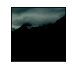

In [ ]:
# Testing if the classes are working

for i, (image, label) in enumerate(train_loader):

    fig, ax = plt.subplots(figsize= (1,1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(image[0], nrow=1).permute(1,2,0))
    classes = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
    print(classes[label[0].item()],'\n', label[0])
    break

In [ ]:
for batch in test_loader:
  image, label = batch[0], batch[1]
  print(batch)
  break

In [ ]:
# Metric and output evaluation functions

def accuracy(outputs, labels):

    # Here presd will hold the index of the tensor which has the maximum value(that value is dumped using underscore) and will act as the 
    # predicted value.

    _, pred = torch.max(outputs, dim = 1)

    return torch.tensor(torch.sum(pred==labels).item()/len(pred))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
"""
Base model for classification
"""
class Base_Architecture(nn.Module):
           
    def training_stage(self, batch):

        images, labels = batch[0], batch[1]
        images, labels = images.to(device), labels.to(device)

        out = self.forward(images)

        # Calculate loss
        loss = F.cross_entropy(out, labels)     # Note we are using cross_entropy instead of binary cross entroppy as it is a multi class classification problem
        return loss
    
    def validation(self, batch):

        images, labels = batch[0], batch[1]
        images, labels = images.to(device), labels.to(device)

        # Passed to the model and the output is returned to out
        out = self.forward(images)

        # The outputs are directly plugged into the cross_entropy function to obtain the losses.
        loss = F.cross_entropy(out, labels)

        # The outputs are also used to calculate the accuracy.
        acc = accuracy(out, labels)

        # What ends up being returned is the validation loss and the validation accuracy in the 
        # form of a dictionary
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_end_epoch(self, results):

        # The dictionary from the above validation function is directly passed to this function to
        # calculate the combined loss of the entire validation set
        batch_losses = [x['val_loss'] for x in results]
        epoch_loss = torch.stack(batch_losses).mean()

        # Same for accuracy
        batch_accs = [x['val_acc'] for x in results]
        epoch_acc = torch.stack(batch_accs).mean()

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):

        print("Epoch[{0}], train_loss: {1:.4f}, val_loss: {2:.4f}, val_acc: {3:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        return

In [ ]:
"""
CNN architecture
"""


class CNN_Architecture(Base_Architecture):


    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(

        # 3 channel image is converted into 32 channels
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),

        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        # Densely connected layers
        nn.Flatten(),
        nn.Linear(82944, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 6)
        )

    def forward(self, inputs):
        return self.network(inputs)


In [ ]:
# Metric and output evaluation functions

@torch.no_grad()
def evaluate(model, val_loader):

    # Getting the model ready for evaluation
    model.eval()
    
    # Outputs are calculated by passing the inputs to the model.validation() function
    ouputs = [model.validation(batch) for batch in val_loader]

    # The outputs obtained above is passed onto the validation_end_epoch function to calculate the accuracy of that epoch
    return model.validation_end_epoch(ouputs)

# Training the model

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.Adam):

    optimizer = opt_func(model.parameters())
    plot_for_loss = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):

        # Getting ready for the model for training
        model.train()

        result = []
        train_losses=[]
        num = 0
        for batch in train_loader:

            num+=1
            print("\nBatch {0}, Epoch {1}/{2}".format(num, epoch+1, epochs))

            # perform the predictions and calculate the loss
            loss = model.training_stage(batch)
            train_losses.append(loss)

            # Optimization step
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Evaluating the validation accuracy in each epoch. 
            # ie; the train and validation accuracy is added up at the same time
            result = evaluate(model, val_loader)

            # Result as of the above line contains only the validation statistics. 
            # The next line will add the training statistics also to the result.
            result['train_loss'] = torch.stack(train_losses).mean().item()

        # After all the statistics have been obtained, the epoch_end() function 
        # is called which will display all the statistics 
        model.epoch_end(epoch, result)
        plot_for_loss['train_loss'].append(result['train_loss'])
        plot_for_loss['val_loss'].append(result['val_loss'])

        # The entire history throughout all the stages of epochs are recorded in history list as well.
    return plot_for_loss

In [11]:
# Now we're going to start the procedure by calling the fit() function

epochs = 25
lr = 0.01

# We should create an instance of the CNN architecture and not the Base_architecture
model = CNN_Architecture()
model.to(device)
for n, p in model.named_parameters():
    print(p.device, '', n)
val_loader = test_loader  # For now

history = fit(epochs, lr, model, train_loader, val_loader)

import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.plot(history['train_loss'])
plt.subplot(1,2,2)
plt.plot(history['val_loss'])
plt.show()

<class 'list'>
IN TRAINING
batch in training - 2


C:\Users\gokul\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TRAINING
batch in training - 2
<class 'list'>
IN TR

KeyboardInterrupt: 